# Show and Tell Demo on Training a Quantum Model on The Iris Species Dataset



## Inital steps will include Exploratory Data Analysis of the Iris Data set:

In [ ]:
!pip install -q qiskit
!pip install -q pylatexenc
!pip install azure-quantum[qiskit]
!pip install -q qiskit_machine_learning

In [34]:
# Load the Iris dataset into the variable 'iris_data'
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets


from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from IPython.display import display
from qiskit.circuit.library import ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, ADAM, SPSA
from qiskit.opflow import PauliSumOp
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms import VQC

In [3]:
iris_data = load_iris()

print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

### Total of 150 samples (instances) with 4 featurers (attributes) and 3 labels (classes)

In [4]:
features = iris_data.data
labels = iris_data.target

print(features.shape)
print(labels.shape)

(150, 4)
(150,)


In [5]:
# View of the features data.

features[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

We see that the features array is not normalised with values of different ranges for example we have [4.3, 7.9] and [0.1, 2.5]. For this approach we will use a simple transformation approach in which we can set the ranges to a [0, 1] interval.

In [6]:
# Fit the scaler to the features data and transform it
features = MinMaxScaler().fit_transform(features)

features.shape

(150, 4)

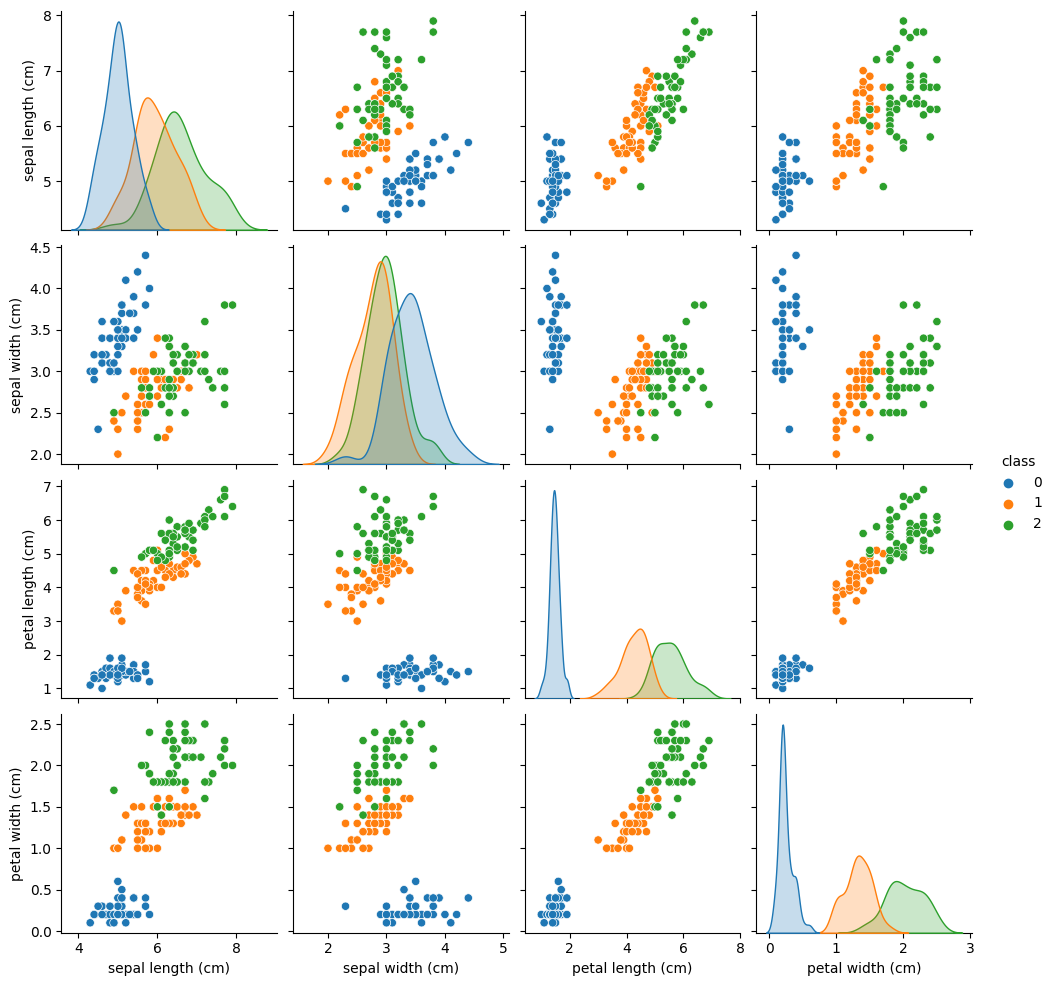

In [7]:
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

From this data visualisation we can see that plots for class 0 potray more separability whilst for class 1 and 2 there is more intertwined relationship especially with the sepal width feature this will contribute to feature engineering.

### Training a classical ML model:
     With a focus on Support Vector Machines:

Using Scikit-learn, the data is split into a train set, validation set and test set.


In [8]:
algorithm_globals.random_seed = 123

# Split the data into train and test sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=algorithm_globals.random_seed
)

# Further split the train set into train and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(
    train_features, train_labels, test_size=0.3, random_state=algorithm_globals.random_seed
)

In [9]:
print(train_features.shape[0])
print(val_features.shape[0])
print(test_features.shape[0])

84
36
30


In [10]:
svc = SVC()
_ = svc.fit(train_features, train_labels)

In [11]:
train_score = svc.score(train_features, train_labels)
validation_score = svc.score(val_features, val_labels)
test_score = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset:   {train_score:.2f}")
print(f"Classical SVC on the validation dataset: {validation_score:.2f}")
print(f"Classical SVC on the test dataset:       {test_score:.2f}")

Classical SVC on the training dataset:   0.99
Classical SVC on the validation dataset: 0.97
Classical SVC on the test dataset:       0.97


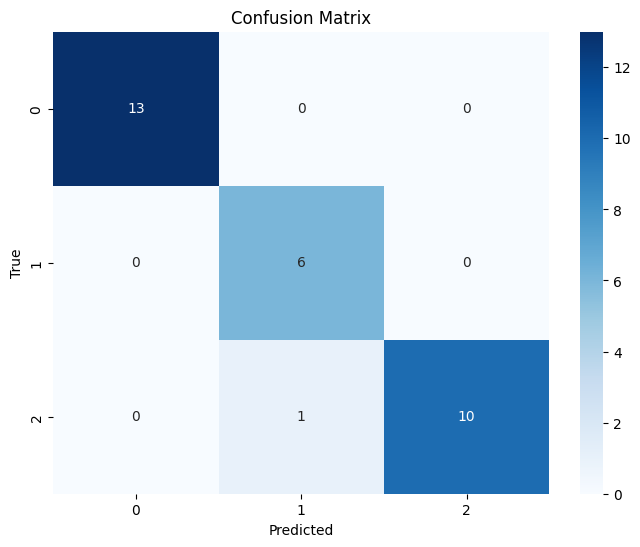

In [12]:
# Assuming you have already trained and obtained predictions from your model
predictions = svc.predict(test_features)

# Confusion Matrix
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# For the next step, explore training a variational quantum classifier (VQC) with the same dataset.

# To implement a simple VQC model we need to examine what comprises of the VQC class

Main elements are:
    1 - Feature Map
    2 - Ansatz

# ZZFeatureMap


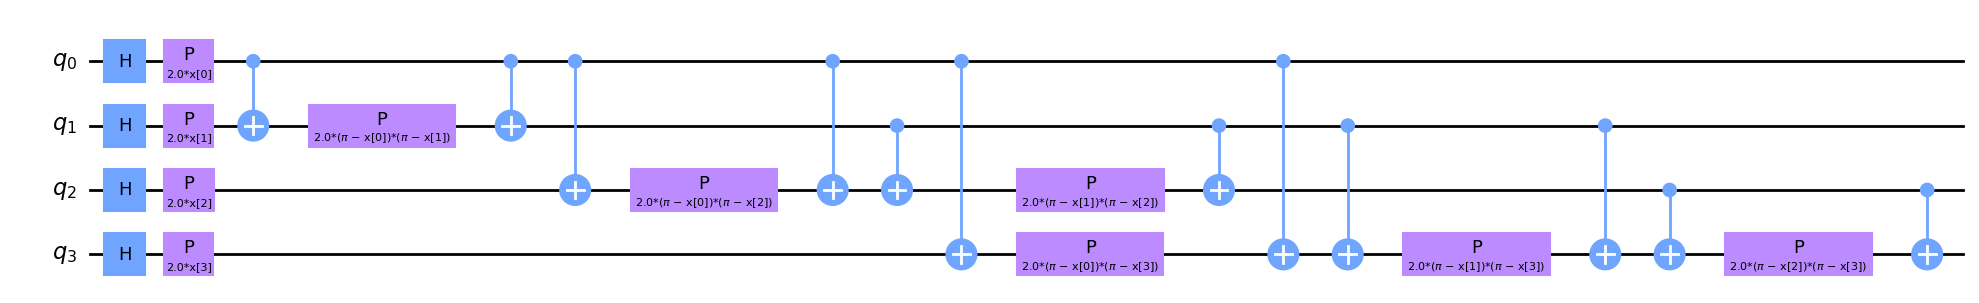

In [13]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=30)

If you look closely at the feature map diagram, you will notice parameters x[0], ..., x[3]. These are placeholders for our features.

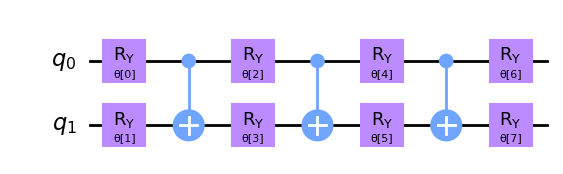

In [30]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

This circuit has 16 parameters named θ[0], ..., θ[15]. These are the trainable weights of the classifier.

We then choose an optimization algorithm to use in the training process. This step is similar to what you may find in classical deep learning frameworks. To make the training process faster, we choose a gradient-free optimizer. You may explore other optimizers available in Qiskit

In [15]:
# Constrained Optimization by Linear Approximation to optimize classical parameters associated with quantum circuits rather than directly optimizing quantum states.

from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

Train classifier on a simulator cause we are still classical.

Introduce the sampler:
A Sampler is a special tool that helps us perform calculations and experiments on the quantum computer or simulator. We create an instance of the Sampler and give it the name "sampler."

In [16]:
from qiskit.primitives import Sampler

sampler = Sampler()

Now, we want to keep track of how well our classifier is doing as it goes through the training process. So, we add something called a "callback function," which is like a special function that gets called or activated at certain points during the training. We give our callback function the name "callback_graph."

In [17]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

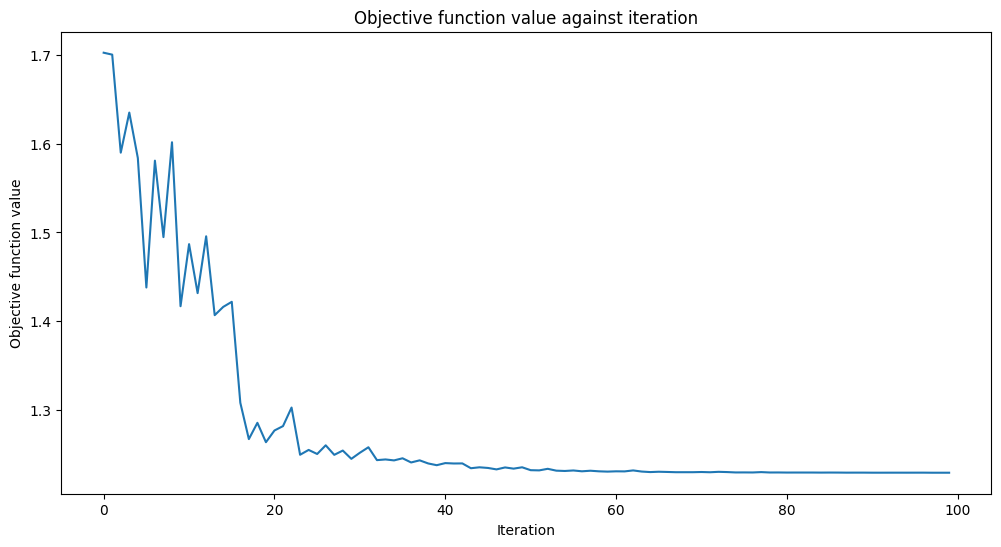

Training time: 91 seconds


In [18]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [19]:
train_score_q4 = vqc.score(train_features, train_labels)
validation_score_q4 = vqc.score(val_features, val_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the validation dataset: {validation_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.63
Quantum VQC on the validation dataset: 0.61
Quantum VQC on the test dataset:     0.60


## Now let’s see what we can tune to get even better models

<Axes: >

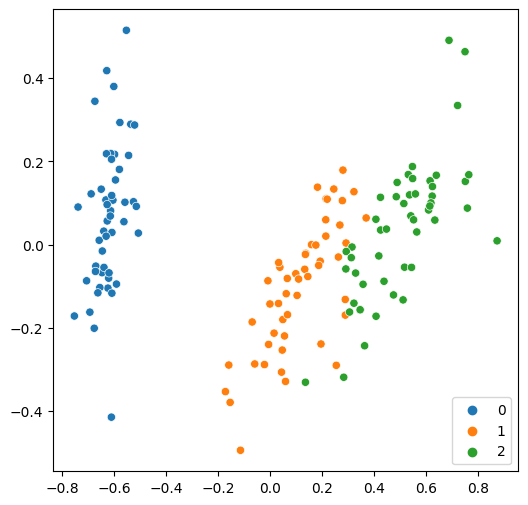

In [20]:
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [21]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset:     0.90


In [22]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

# Select the ideal Optimiser

In [23]:
optimizer = COBYLA(maxiter=40)

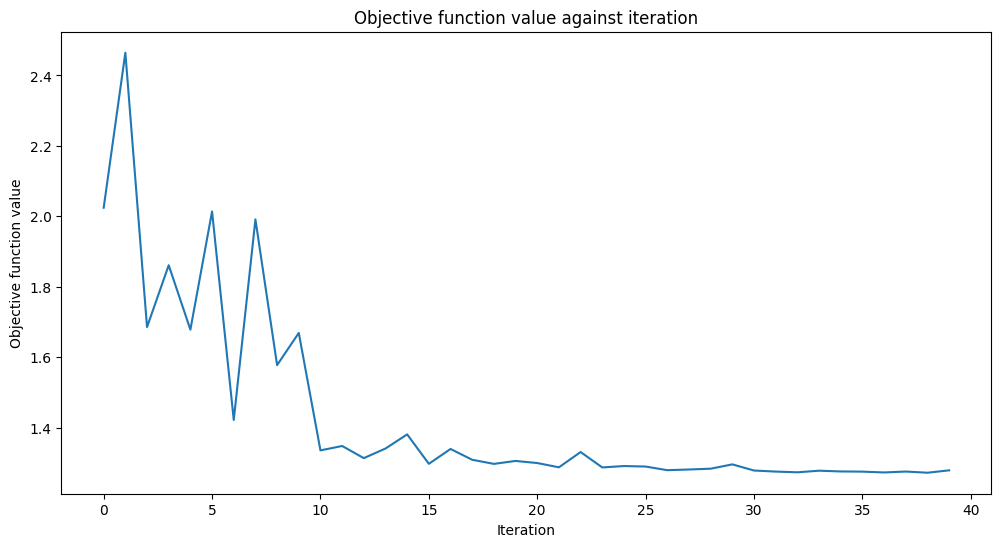

Training time: 31 seconds


In [24]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [25]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.57
Quantum VQC on the test dataset using RealAmplitudes:     0.60


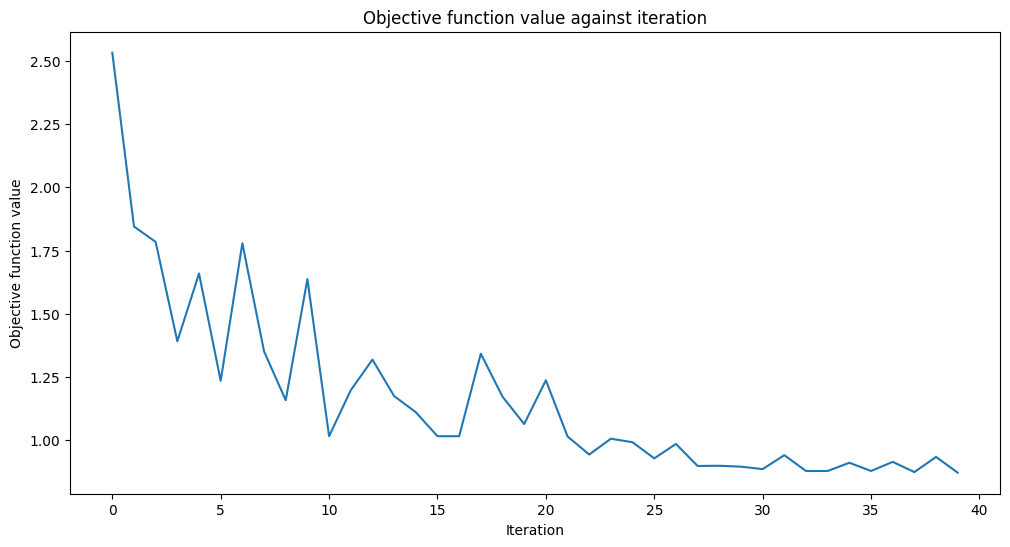

Training time: 36 seconds


In [26]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=40)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [27]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.77
Quantum VQC on the test dataset using EfficientSU2:     0.80


In [31]:
print(f"Model                           | Test Score | Train Score")
print(f"SVC, 4 features                 | {train_score:10.2f} | {test_score:10.2f}")
print(f"VQC, 4 features, RealAmplitudes | {train_score_q4:10.2f} | {test_score_q4:10.2f}")
print(f"----------------------------------------------------------")
print(f"SVC, 2 features                 | {train_score_c2:10.2f} | {test_score_c2:10.2f}")
print(f"VQC, 2 features, RealAmplitudes | {train_score_q2_ra:10.2f} | {test_score_q2_ra:10.2f}")
print(f"VQC, 2 features, EfficientSU2   | {train_score_q2_eff:10.2f} | {test_score_q2_eff:10.2f}")

Model                           | Test Score | Train Score
SVC, 4 features                 |       0.99 |       0.97
VQC, 4 features, RealAmplitudes |       0.63 |       0.60
----------------------------------------------------------
SVC, 2 features                 |       0.97 |       0.90
VQC, 2 features, RealAmplitudes |       0.57 |       0.60
VQC, 2 features, EfficientSU2   |       0.77 |       0.80


In [44]:
X = train_features
y = train_labels

# Define the feature map
feature_map = ZZFeatureMap(feature_dimension=2, reps=1)

# Define the callback function for plotting
def callback_graph(eval_count, parameters, mean, std):
    plt.scatter(eval_count, mean, color='blue')
    plt.xlabel('Evaluation Count')
    plt.ylabel('Objective Function Value')
    plt.title('Training Progress')
    plt.show()

# Define the interactive components
reps_slider = widgets.IntSlider(value=1, min=1, max=15, description='Repetitions:')
optimizer_dropdown = widgets.Dropdown(options=['COBYLA', 'SPSA', 'ADAM'], value='COBYLA', description='Optimizer:')
maxiter_slider = widgets.IntSlider(value=100, min=10, max=500, step=10, description='Max Iterations:')
train_button = widgets.Button(description='Train')

# Define the training function
def train_classifier(b):
    # Get the selected values from the interactive components
    reps = reps_slider.value
    optimizer_name = optimizer_dropdown.value
    max_iterations = maxiter_slider.value

    # Create the VQC classifier with the selected feature map and optimizer
    if optimizer_name == 'COBYLA':
        optimizer = COBYLA(maxiter=max_iterations)
    elif optimizer_name == 'SPSA':
        optimizer = SPSA(maxiter=max_iterations)
    elif optimizer_name == 'ADAM':
        optimizer = ADAM(maxiter=max_iterations)

    vqc = VQC(feature_map, optimizer, callback=callback_graph)

    # Train the classifier with the selected repetitions
    vqc.fit(X, y, quantum_instance=QuantumInstance(backend=None, shots=1024), parameterized_circuits=reps)

    # Evaluate the trained classifier on the training set
    y_pred = vqc.predict(X)

    # Calculate accuracy
    accuracy = np.mean(y_pred == y) * 100

    # Print the training results
    print(f"Training Results:")
    print(f"Number of Repetitions: {reps}")
    print(f"Optimizer: {optimizer_name}")
    print(f"Max Iterations: {max_iterations}")
    print(f"Accuracy on Training Set: {accuracy}%")

# Attach the training function to the button click event
train_button.on_click(train_classifier)

# Display the interactive components
display(reps_slider, optimizer_dropdown, maxiter_slider, train_button)

IntSlider(value=1, description='Repetitions:', max=15, min=1)

Dropdown(description='Optimizer:', options=('COBYLA', 'SPSA', 'ADAM'), value='COBYLA')

IntSlider(value=100, description='Max Iterations:', max=500, min=10, step=10)

Button(description='Train', style=ButtonStyle())